# Offline rule - Persistence Time
I want to characteriste how the weights of the connectivity matrix behave with different combinations of parameters:
* Training_time
* tau_z
* Resting Time
* ISI
* IPI
* Number of units

In [7]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix

In [61]:
epsilon = 10e-10

## An example

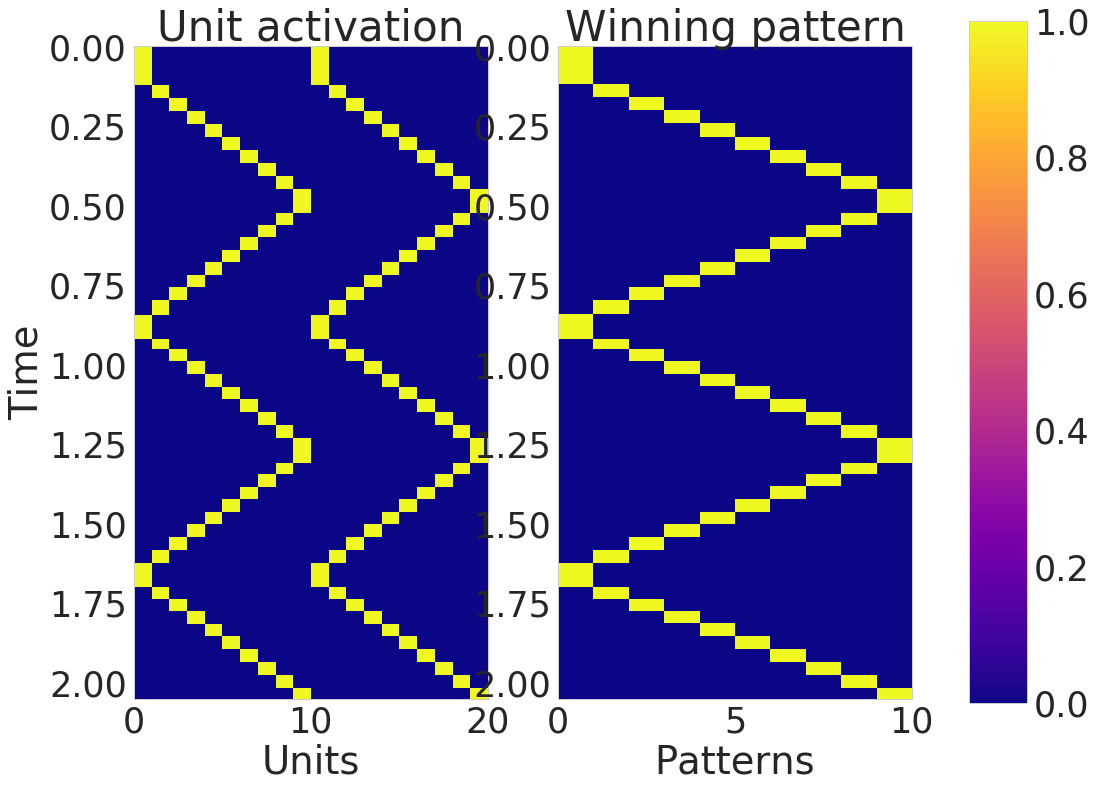

In [113]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.150
tau_z_post_ampa = tau_z_pre_ampa
tau_p = 10.0

hypercolumns = 2
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

timed_input = TimedInput(network_representation, dt, training_time, 
                         inter_pulse_interval=inter_pulse_interval, 
                         inter_sequence_interval=inter_sequence_interval, 
                         epochs=epochs, resting_time=resting_time)


S = timed_input.build_timed_input()
z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
z_post = timed_input.build_filtered_input_post(tau_z_post_ampa)

pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, small_number=epsilon)


# Patterns parameters

nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
nn.w_ampa = w_timed

# Recall
patterns_indexes = [i for i in range(n_patterns)]
sequences = [patterns_indexes]
# manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
total_sequence_time, mean, std, success, timings = aux

plot_network_activity_angle(manager)

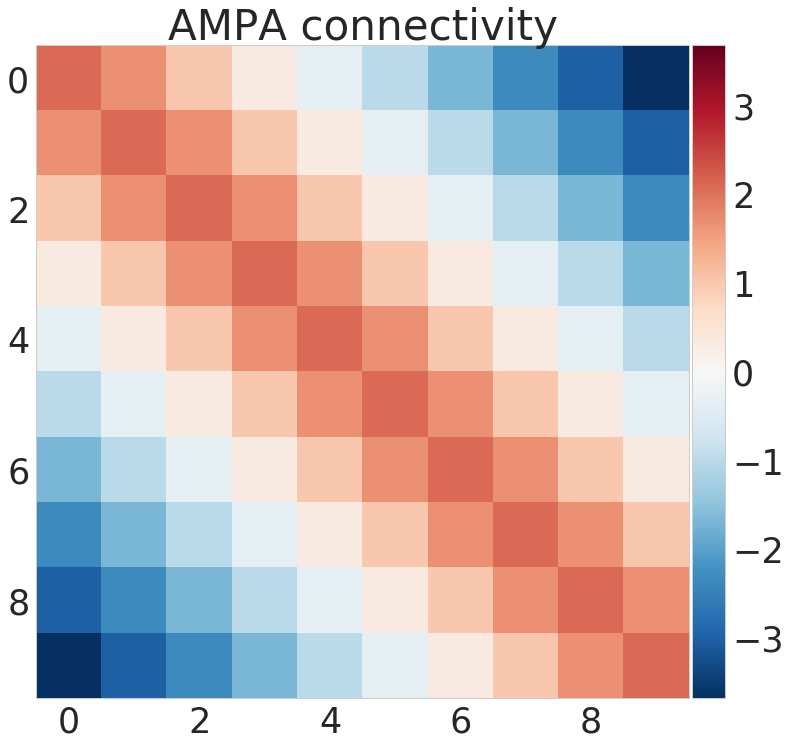

In [116]:
plot_weight_matrix(nn, ampa=True)

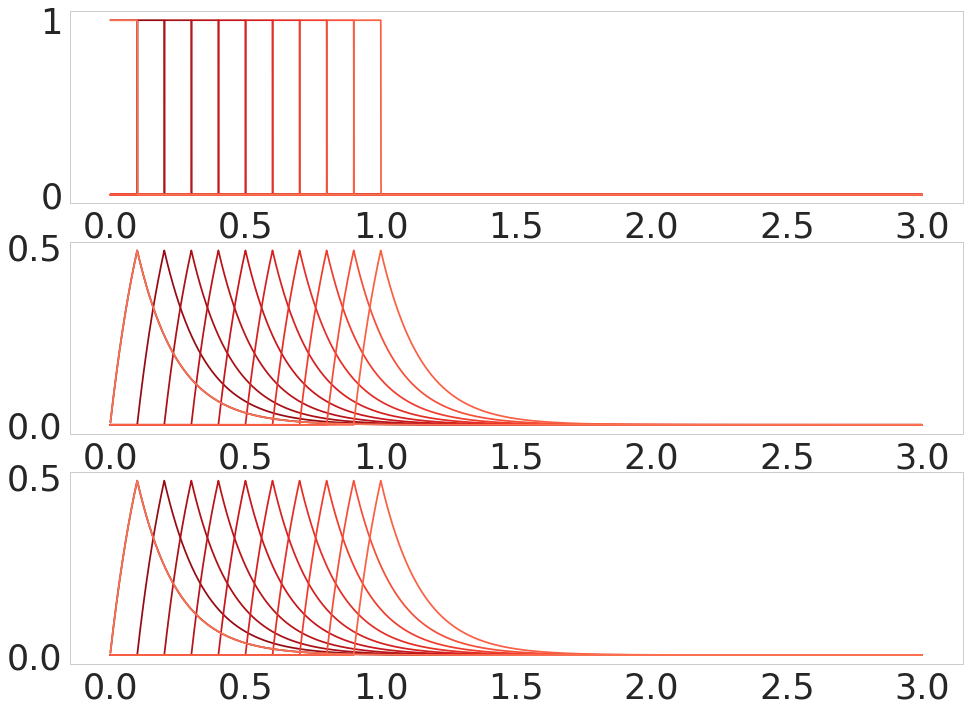

In [117]:
palette = sns.color_palette("Reds_r", S.shape[0])
figsize = (16, 12)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for index, s in enumerate(S):
    if index < 11:
        ax1.plot(timed_input.time, s, color=palette[index])
        ax2.plot(timed_input.time, z_pre[index, :], color=palette[index])
        ax3.plot(timed_input.time, z_post[index, :], color=palette[index])

In [118]:
from_pattern = 2
to_pattern = 3

w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)

# Calibration for resting time

In [14]:
w_self_vector, w_next_vector, w_rest_matrix = get_weights_collections(w_timed, patterns_indexes)

In [15]:
w_next_vector

array([ 1.53673,  1.53671,  1.53671,  1.53672,  1.53672,  1.53672,
        1.53673,  1.53674,  1.53677])

In [16]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

In [17]:
num = 15
num_rt = 15
tau_z_vector = np.linspace(0.025, 0.500, num=num)
resting_time_vector = np.linspace(0, 3.0, num=num_rt)
self_std_vector = np.zeros((num, num_rt))
next_std_vector = np.zeros((num, num_rt))

for index1, tau_z_pre_ampa_ in enumerate(tau_z_vector):
    for index2, resting_time_ in enumerate(resting_time_vector):
        matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
        network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

        timed_input = TimedInput(network_representation, dt, training_time, 
                                inter_pulse_interval=inter_pulse_interval, 
                                inter_sequence_interval=inter_sequence_interval, 
                                epochs=epochs, resting_time=resting_time_)

        S = timed_input.build_timed_input()
        z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa_)
        z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa_)

        pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
        w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)
        
        w_self_vector, w_next_vector, w_rest_matrix = get_weights_collections(w_timed, patterns_indexes)
        self_std_vector[index1, index2] = w_self_vector.std()
        next_std_vector[index1, index2] = w_next_vector.std()

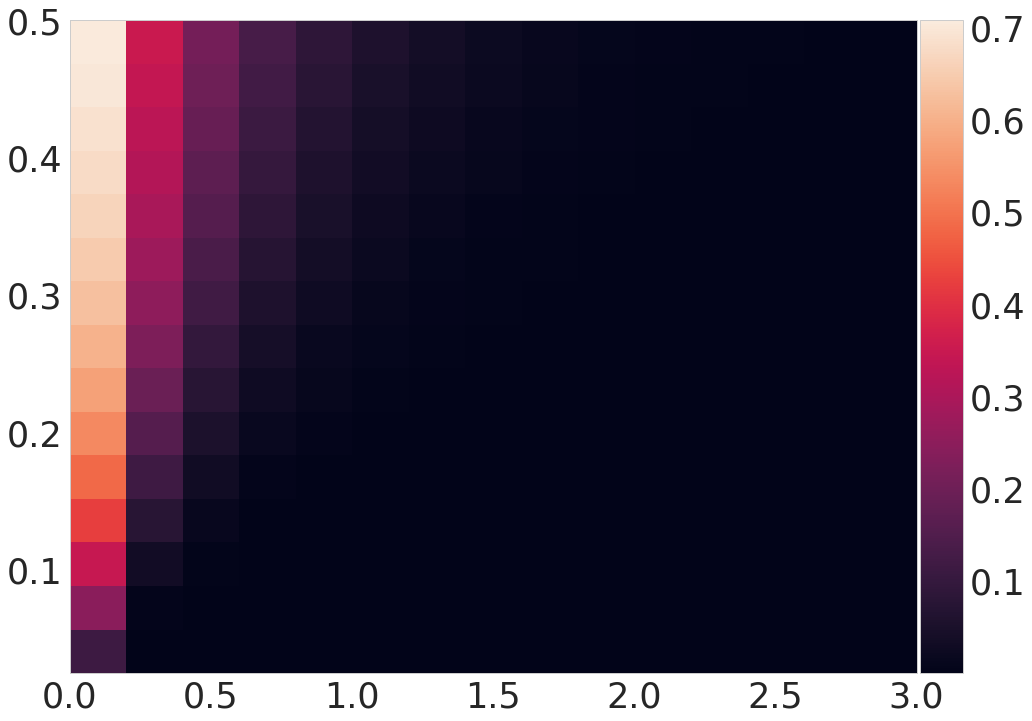

In [18]:
extent = [resting_time_vector[0], resting_time_vector[-1], tau_z_vector[0], tau_z_vector[-1]]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

im = ax.imshow(self_std_vector, extent=extent, origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

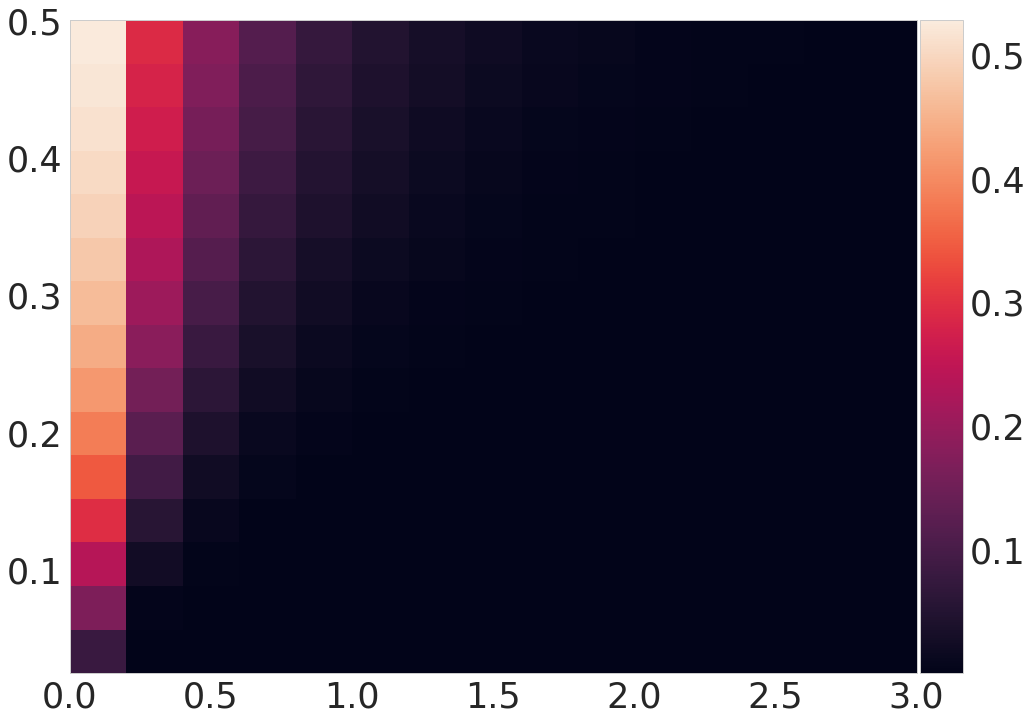

In [19]:
extent = [resting_time_vector[0], resting_time_vector[-1], tau_z_vector[0], tau_z_vector[-1]]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)

im = ax.imshow(next_std_vector, extent=extent, origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

## Training time

In [126]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 20
training_times = np.linspace(0.050, 1.0, num=num)
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)

w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

pi_self_vector = np.zeros(num)
Pij_self_vector = np.zeros(num)
pi_next_vector = np.zeros(num)
Pij_next_vector = np.zeros(num)
pi_rest_vector = np.zeros(num)
Pij_rest_vector = np.zeros(num)

for index, training_time_ in enumerate(training_times):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time_, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest
    
    pi_self_vector[index] = pi[from_pattern] * pj[from_pattern]
    Pij_self_vector[index] = P[from_pattern, from_pattern]
    pi_next_vector[index] = pi[from_pattern] * pj[to_pattern]
    Pij_next_vector[index] = P[to_pattern, from_pattern]
    pi_rest_vector[index] = pi[from_pattern] * pj[to_pattern + 1]
    Pij_rest_vector[index] = P[to_pattern + 1, from_pattern]

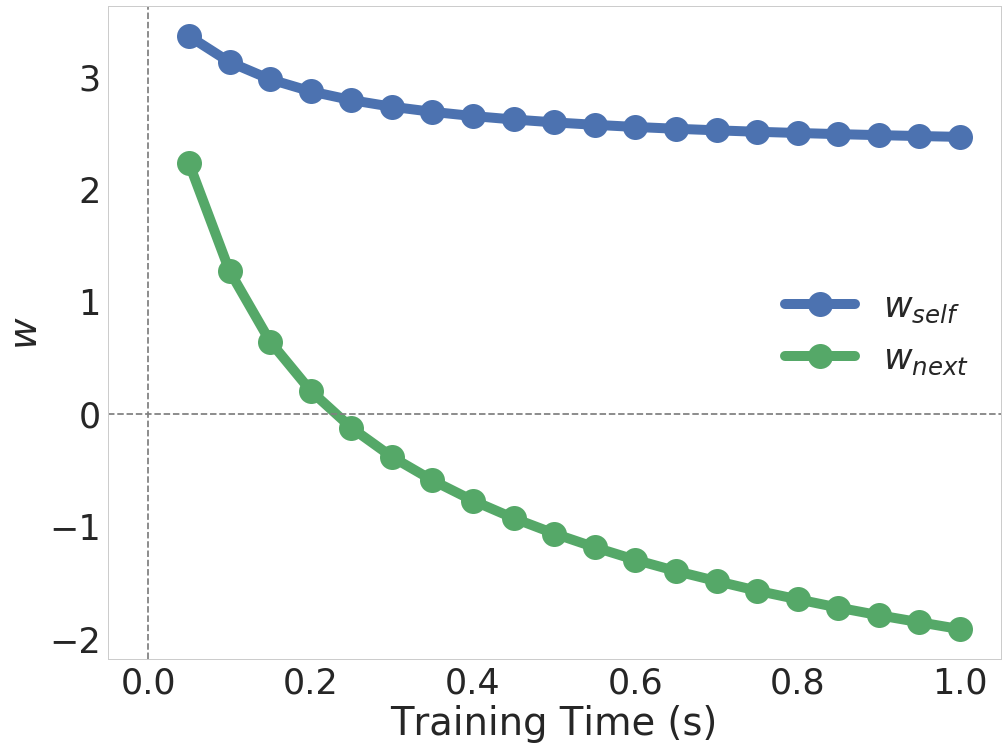

In [129]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(training_times, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(training_times, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
#ax.plot(training_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Training Time (s)')
ax.legend();

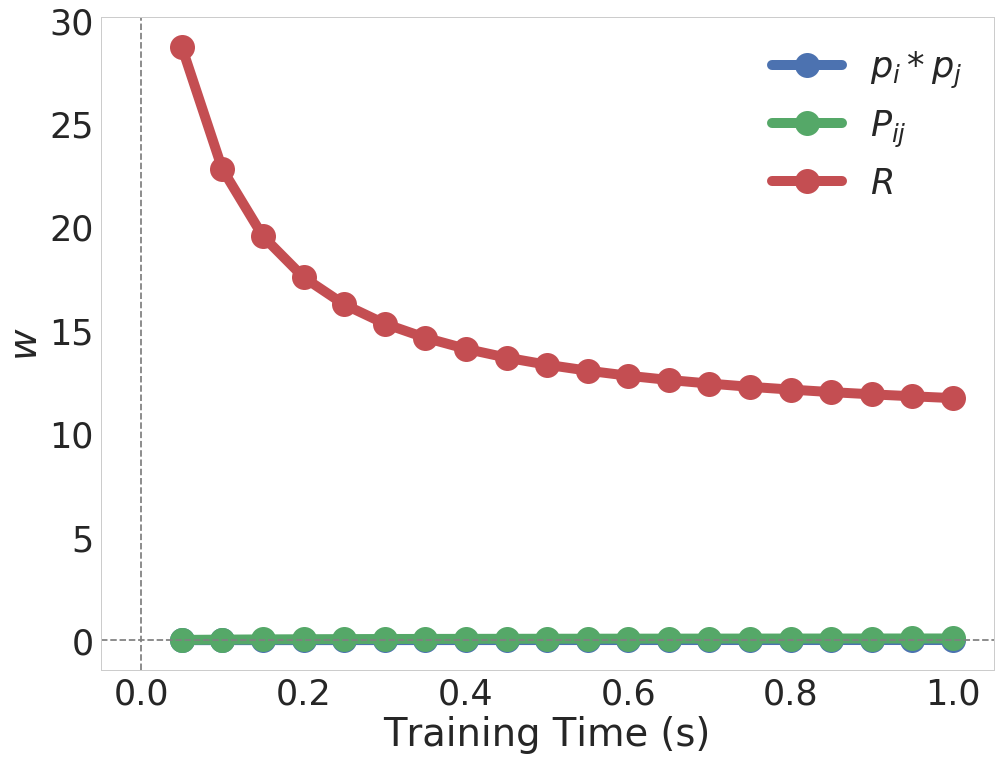

In [135]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(training_times,  pi_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$p_i * p_j $')
ax.plot(training_times, Pij_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$P_{ij}$')
ax.plot(training_times, Pij_self_vector / pi_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$R$')

#ax.plot(training_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Training Time (s)')
ax.legend();

In [ ]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(training_times, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(training_times, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
#ax.plot(training_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'probabilities')
ax.set_xlabel(r'Training Time (s)')
ax.legend();

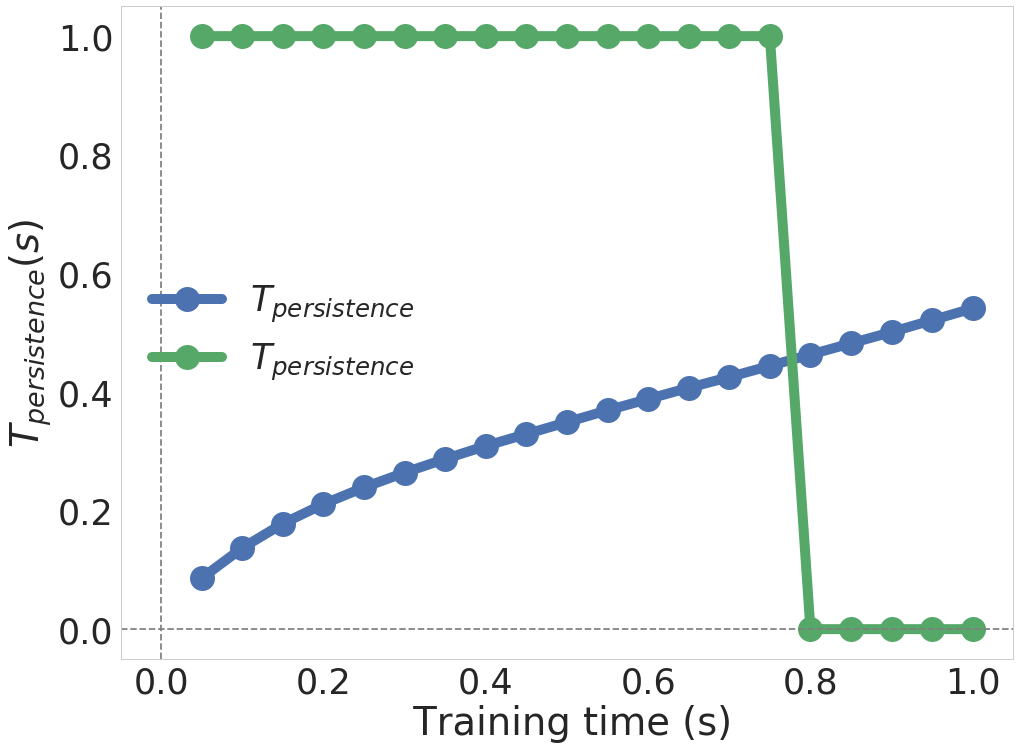

In [125]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(training_times, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(training_times, success_vector / 100.0, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')



ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r' Training time (s)')
ax.legend();

## tau_z

In [23]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

num = 15
tau_z_vector = np.linspace(0.025, 0.250, num=num)
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, tau_z_pre_ampa_ in enumerate(tau_z_vector):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa_)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa_)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa_, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

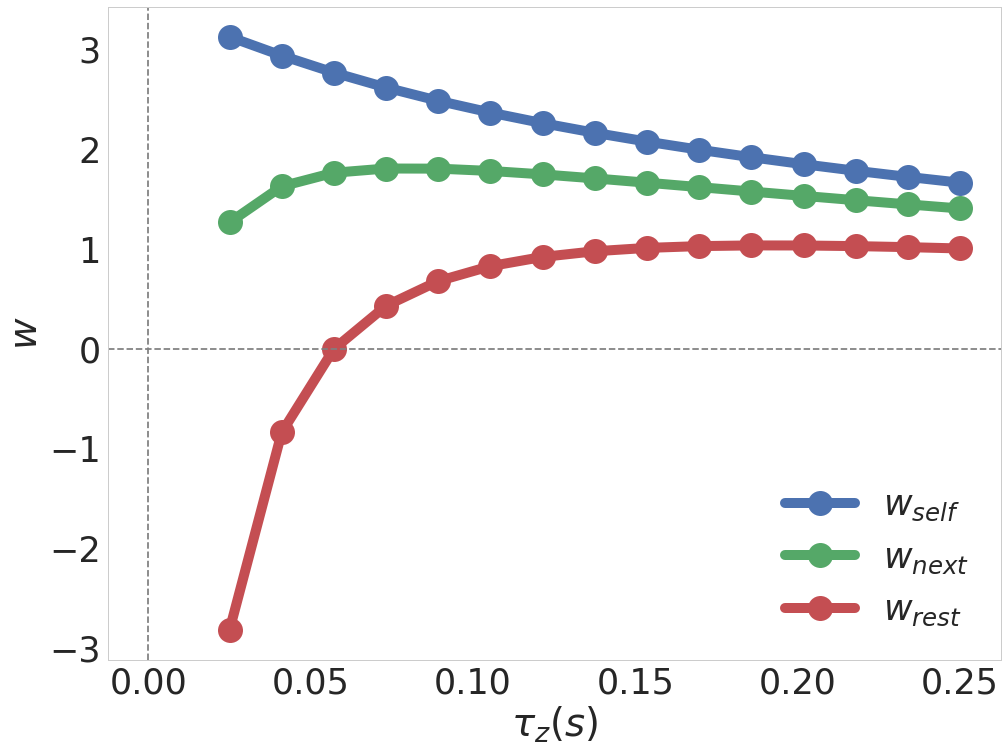

In [24]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(tau_z_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(tau_z_vector, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'$\tau_z (s)$')
ax.legend();

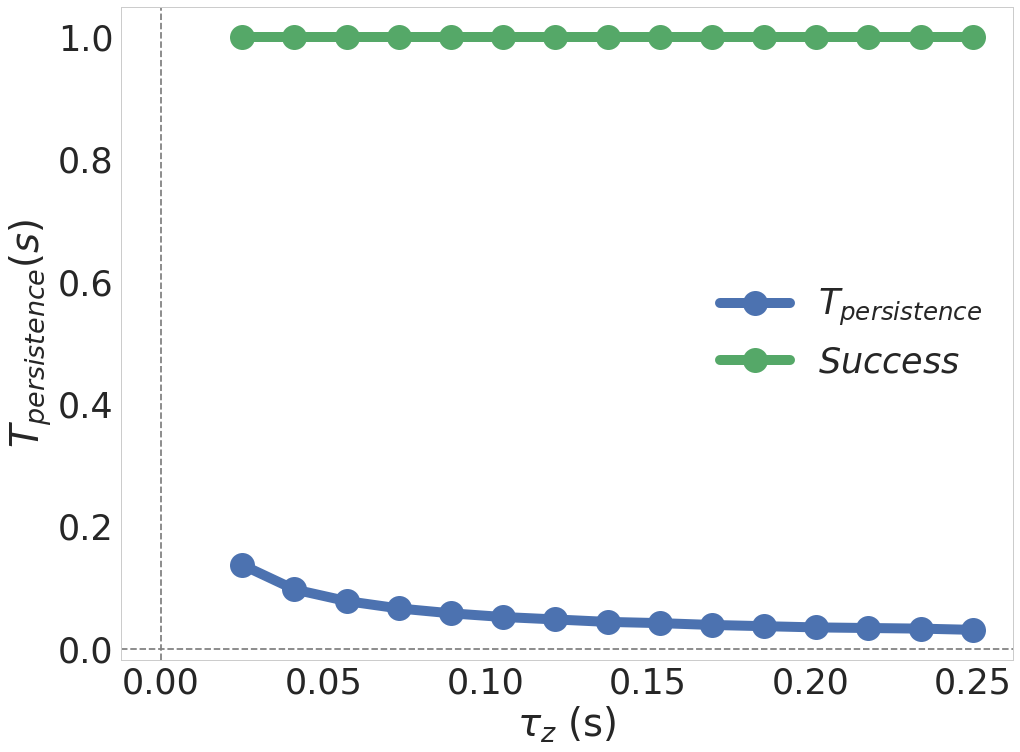

In [25]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(tau_z_vector, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(tau_z_vector, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'$\tau_z$ (s)')
ax.legend();

## Resting time

In [26]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

num = 15
resting_times = np.linspace(0.0, 3.0, num=num)
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, resting_time_ in enumerate(resting_times):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time_)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

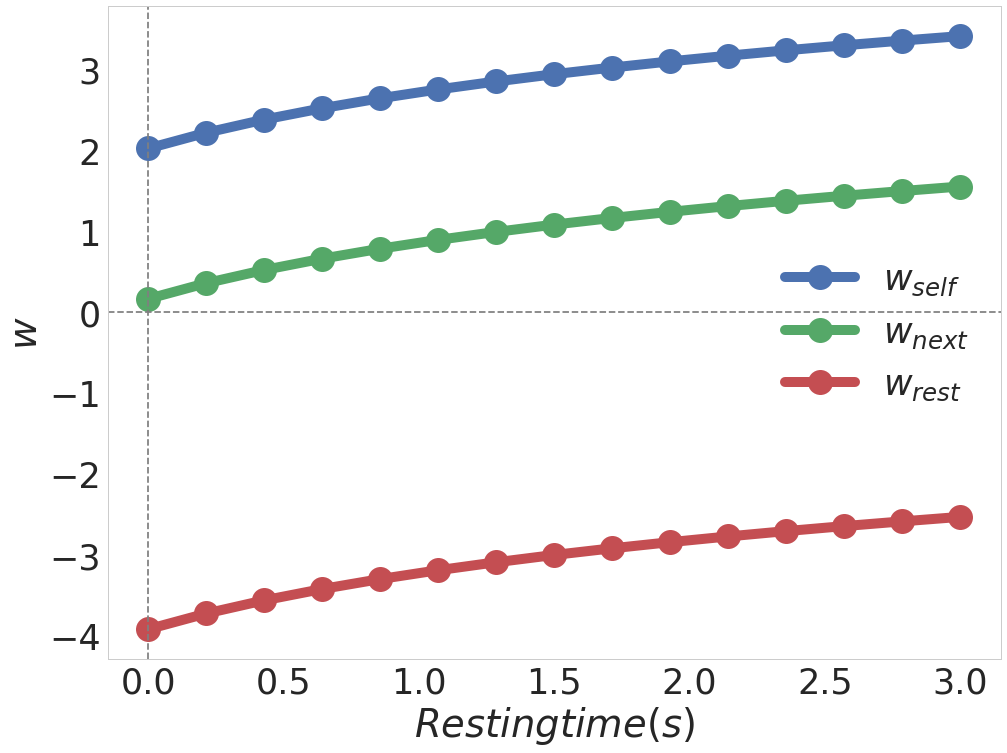

In [27]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(resting_times, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(resting_times, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(resting_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Resting time (s)$')
ax.legend();

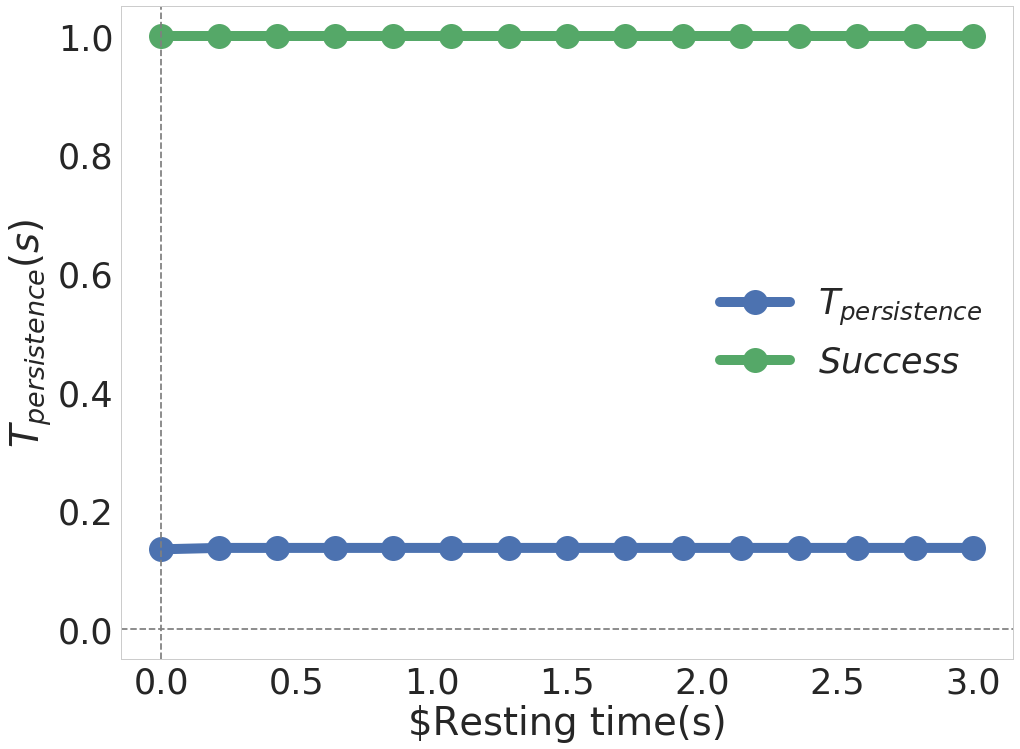

In [28]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(resting_times, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(resting_times, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'Resting time(s)')
ax.legend();

## Epochs

In [32]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

num = 15
epochs_vector = np.arange(1, 10, 1, dtype='int')
success_vector = np.zeros(epochs_vector.size)
persistence_time_vector = np.zeros(epochs_vector.size)
w_self_vector = np.zeros(epochs_vector.size)
w_next_vector = np.zeros(epochs_vector.size)
w_rest_vector = np.zeros(epochs_vector.size)

for index, epochs_ in enumerate(epochs_vector):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs_, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

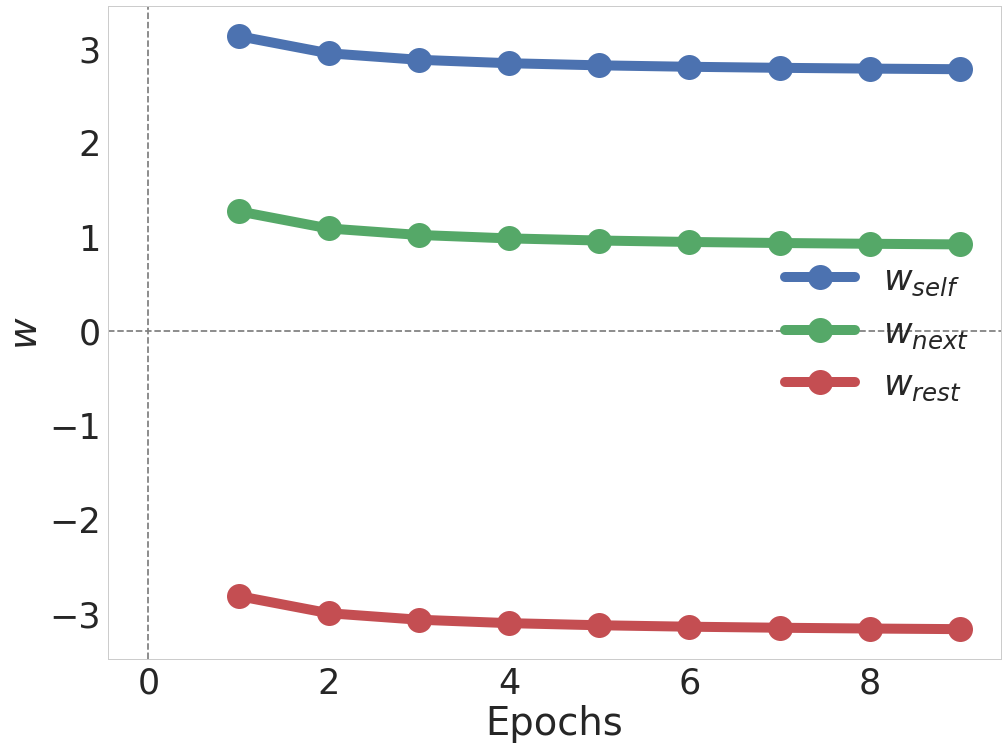

In [36]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(epochs_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(epochs_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(epochs_vector, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Epochs')
ax.legend();

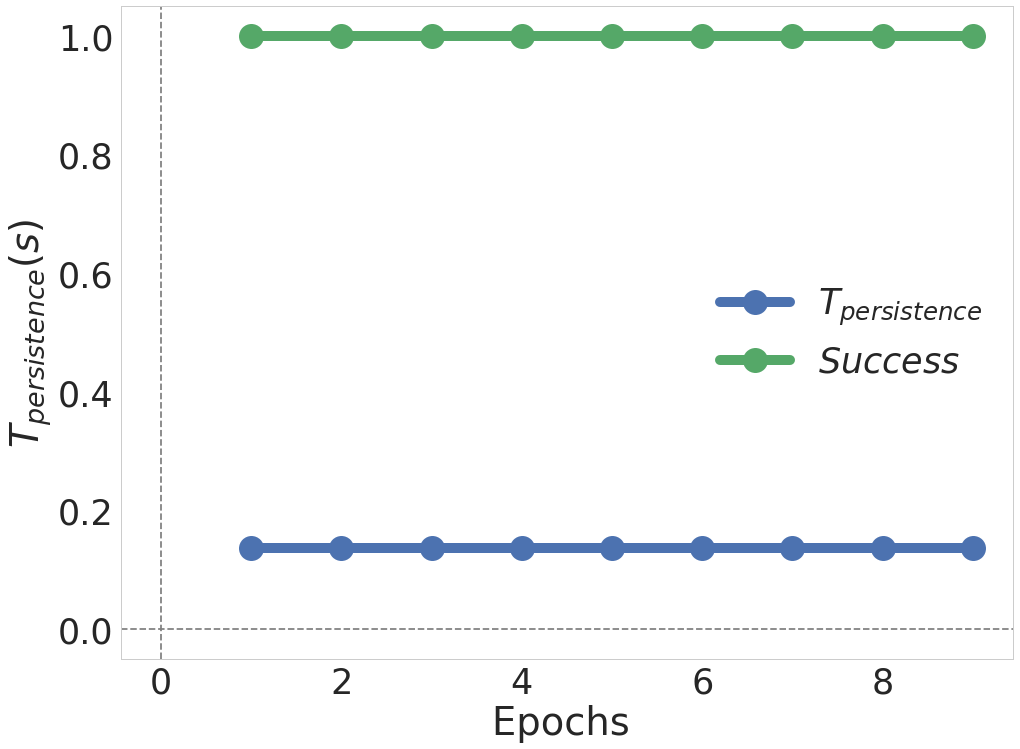

In [35]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(epochs_vector, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(epochs_vector, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'Epochs ')
ax.legend();

## Inter sequence times

In [29]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.025
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 3
resting_time = 2.0

# Recall
T_recall = 2.0
n = 1
T_cue = 0.050

num = 15
inter_sequence_times = np.linspace(0.0, 3.0, num=num)
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, inter_sequence_interval_ in enumerate(inter_sequence_times):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval_, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

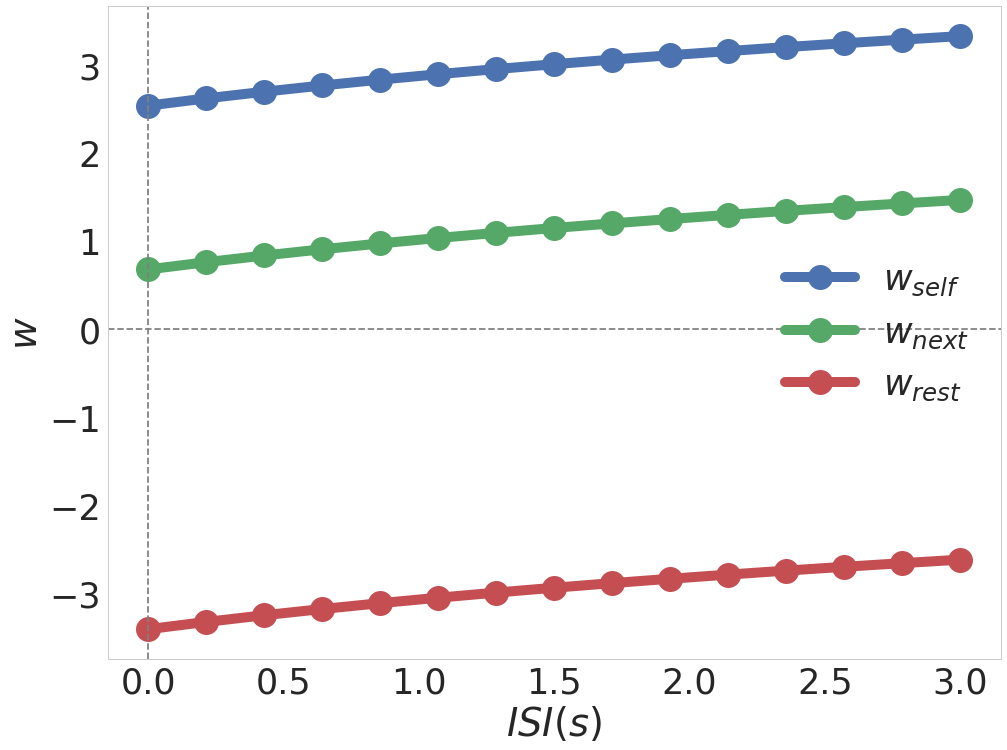

In [30]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(inter_sequence_times, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(inter_sequence_times, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(inter_sequence_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'$ISI (s)$')
ax.legend();

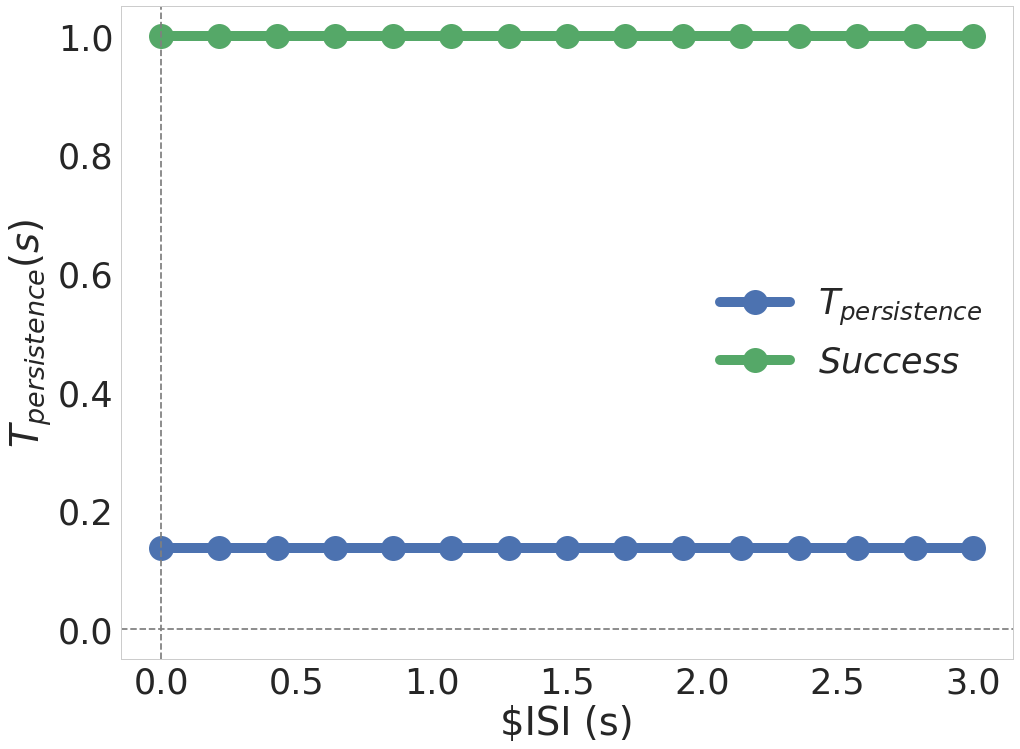

In [31]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(inter_sequence_times, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(inter_sequence_times, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'ISI (s)')
ax.legend();

## Inter Pulse interval

In [43]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.150
tau_z_post_ampa = 0.150
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 15
inter_pulse_times = np.linspace(0.0, 1.0, num=num)
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, inter_pulse_interval_ in enumerate(inter_pulse_times):

    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval_, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


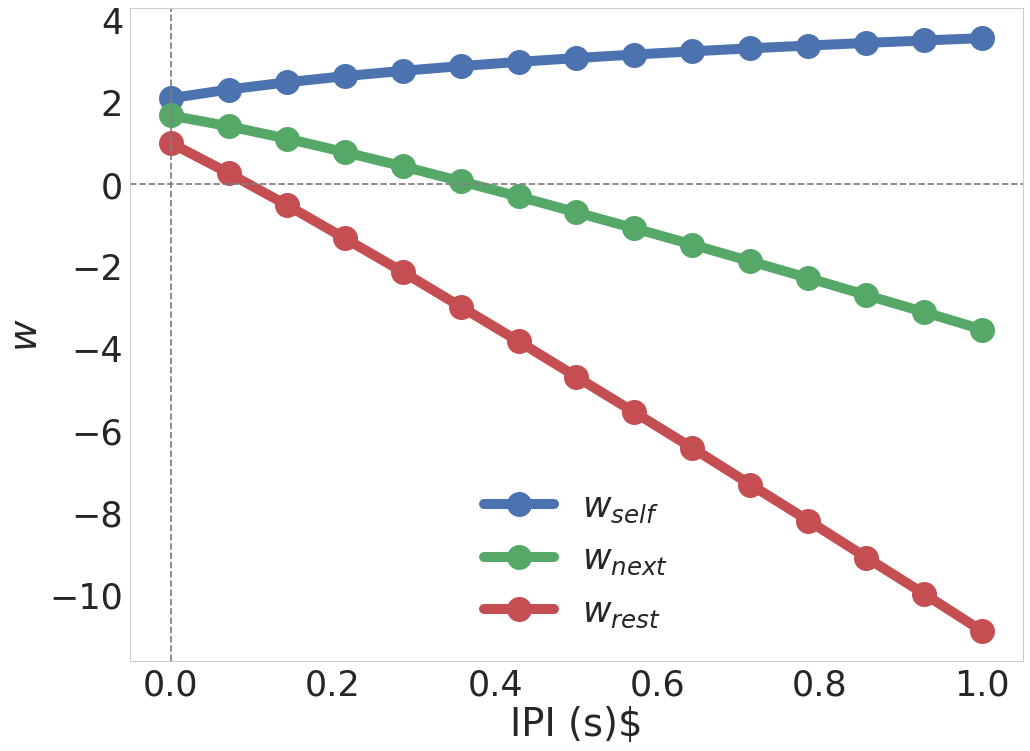

In [44]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(inter_pulse_times, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(inter_pulse_times, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(inter_pulse_times, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'IPI (s)$')
ax.legend();

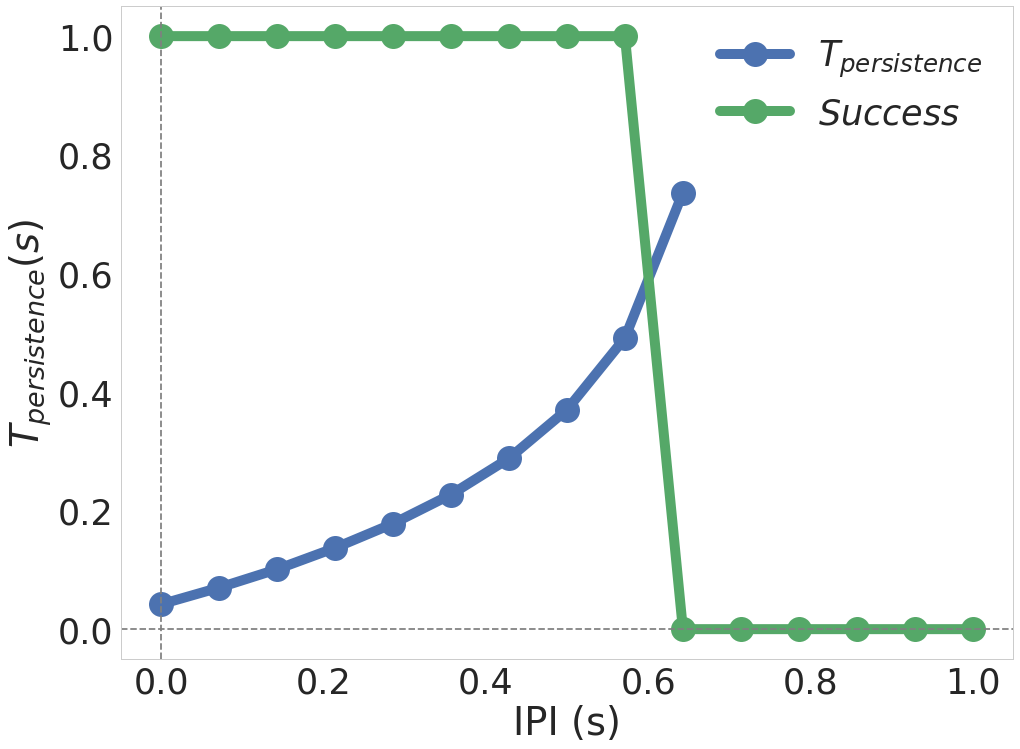

In [45]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(inter_pulse_times, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(inter_pulse_times, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'IPI (s)')
ax.legend();

## Minicolumns

In [88]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.150
tau_z_post_ampa = 0.150
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 15
minicolumns_vector = np.linspace(10, 50, num=num, dtype='int')
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, minicolumns_ in enumerate(minicolumns_vector):

    matrix = create_orthogonal_canonical_representation(minicolumns_, hypercolumns)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns_, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns_, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns_, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

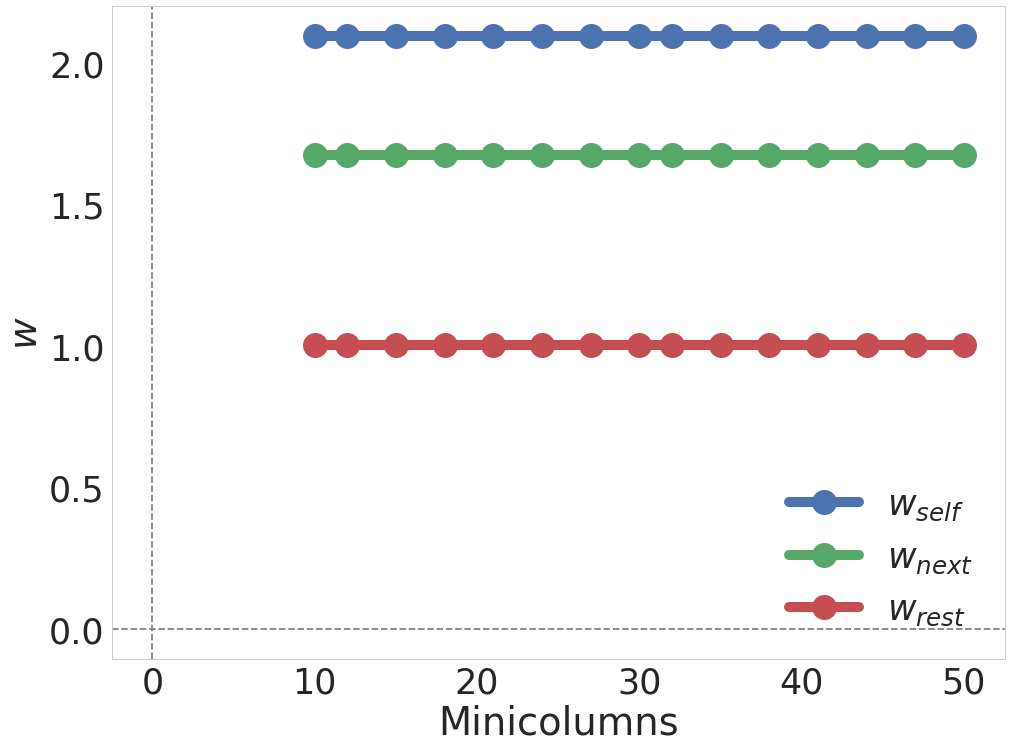

In [89]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(minicolumns_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(minicolumns_vector, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Minicolumns')
ax.legend();

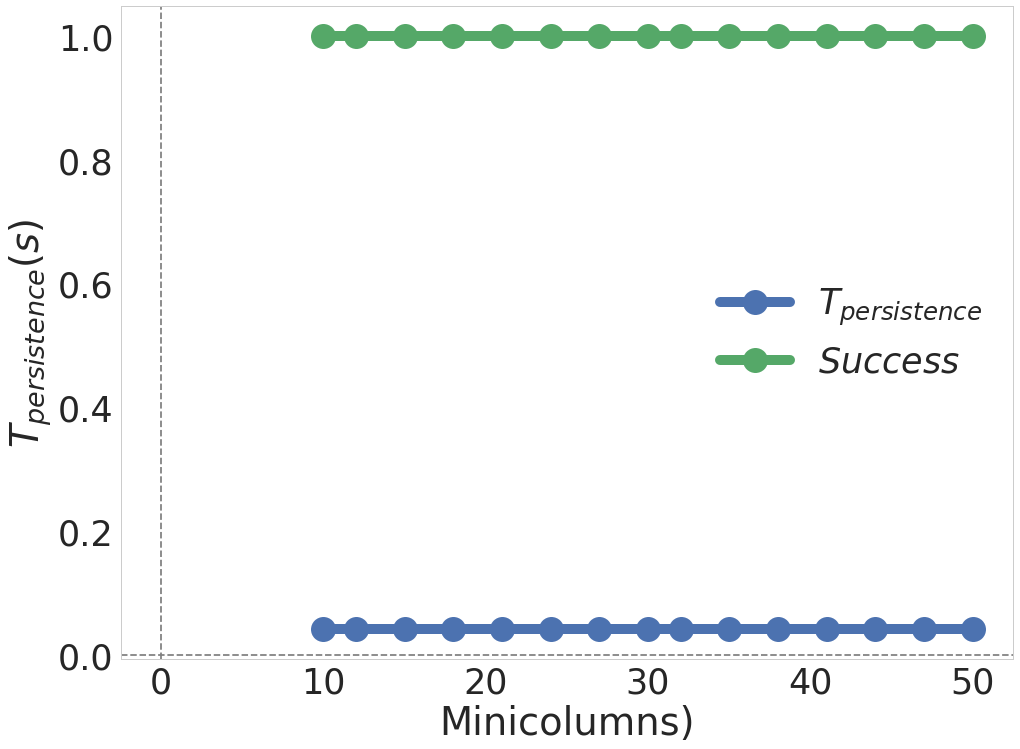

In [90]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(minicolumns_vector, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'Minicolumns)')
ax.legend();

## Minicoluns 2

In [84]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.150
tau_z_post_ampa = 0.150
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 15
minicolumns_vector = np.linspace(10, 50, num=num, dtype='int')
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, minicolumns_ in enumerate(minicolumns_vector):
    n_patterns_ = minicolumns_
    matrix = create_orthogonal_canonical_representation(minicolumns_, hypercolumns)[:n_patterns_]
    network_representation = build_network_representation(matrix, minicolumns_, hypercolumns)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns_, hypercolumns, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns, minicolumns_, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns_)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

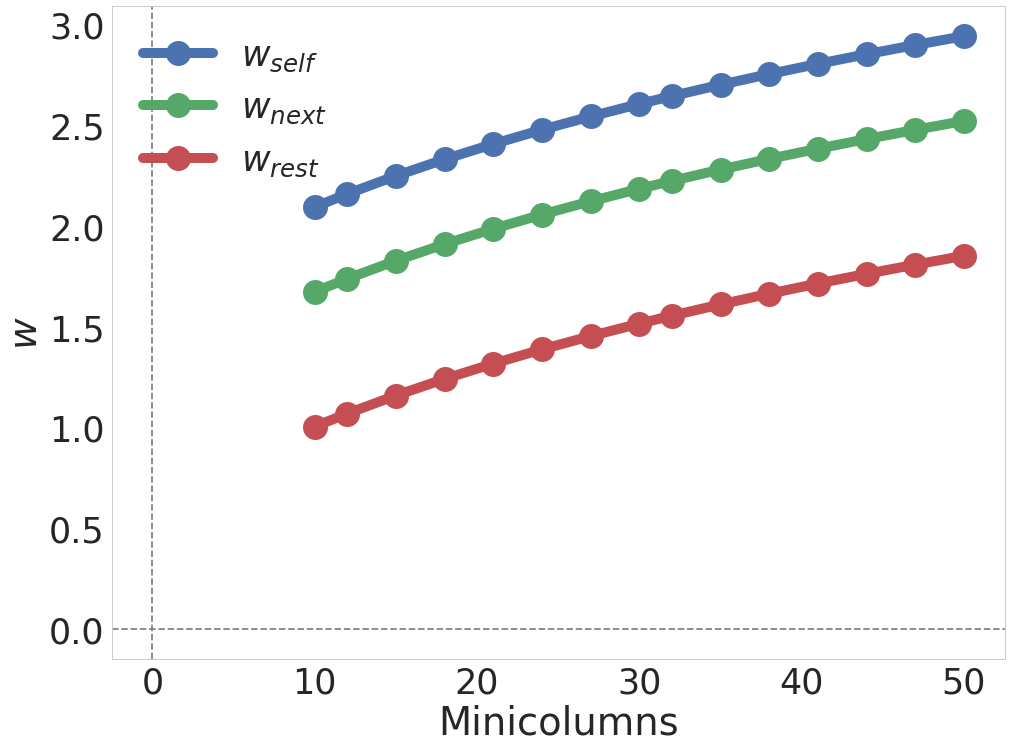

In [85]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(minicolumns_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(minicolumns_vector, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Minicolumns')
ax.legend();

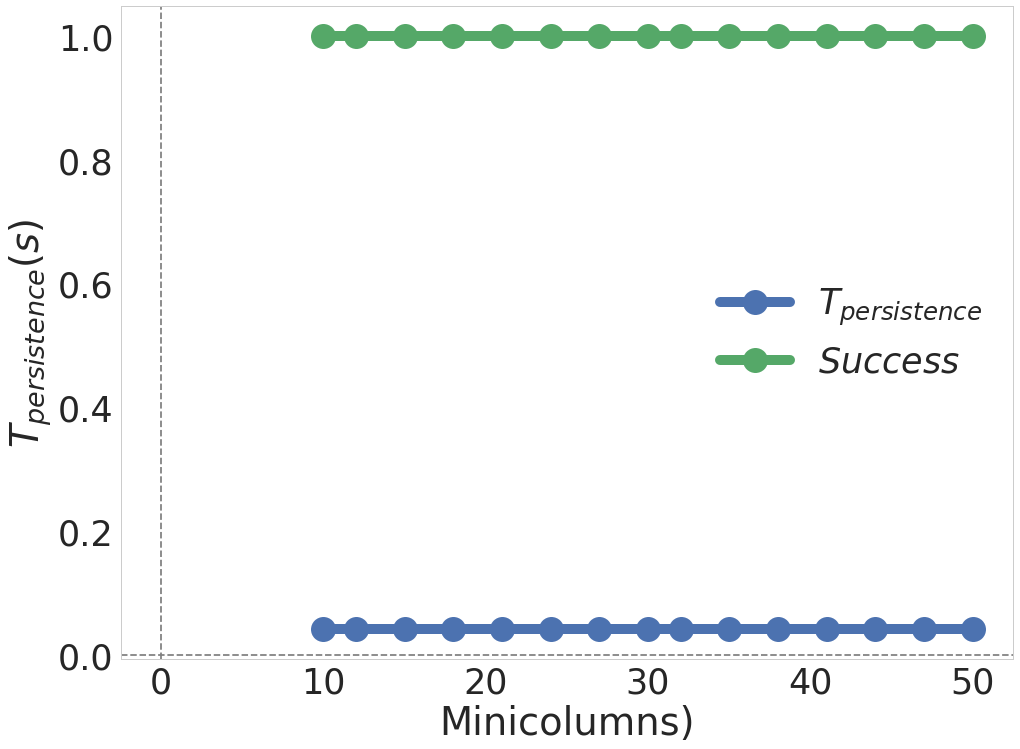

In [86]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(minicolumns_vector, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(minicolumns_vector, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'Minicolumns)')
ax.legend();

## Hypercolumns

In [105]:
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 2.0
g_w = 0.0
g_a = 10.0
tau_a = 0.250
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.150
tau_z_post_ampa = 0.150
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 1
resting_time = 2.0

# Recall
T_recall = 3.0
n = 1
T_cue = 0.050

num = 10
hypercolumns_vector = np.linspace(1, 10, num=num, dtype='int')
success_vector = np.zeros(num)
persistence_time_vector = np.zeros(num)
w_self_vector = np.zeros(num)
w_next_vector = np.zeros(num)
w_rest_vector = np.zeros(num)

for index, hypercolumns_ in enumerate(hypercolumns_vector):
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns_)[:n_patterns]
    network_representation = build_network_representation(matrix, minicolumns, hypercolumns_)

    timed_input = TimedInput(network_representation, dt, training_time, 
                            inter_pulse_interval=inter_pulse_interval, 
                            inter_sequence_interval=inter_sequence_interval, 
                            epochs=epochs, resting_time=resting_time)
    
    S = timed_input.build_timed_input()
    z_pre = timed_input.build_filtered_input_pre(tau_z_pre_ampa)
    z_post = timed_input.build_filtered_input_post(tau_z_pre_ampa)

    pi, pj, P = timed_input.calculate_probabilities_from_time_signal(filtered=True)
    w_timed, beta_timed = get_weights_from_probabilities(pi, pj, P, minicolumns, hypercolumns_, epsilon)


    # Patterns parameters

    nn = BCPNNPerfect(hypercolumns_, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                      sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                      z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Build the protocol for training
    nn.w_ampa = w_timed

    # Recall
    patterns_indexes = [i for i in range(n_patterns)]
    sequences = [patterns_indexes]
    # manager.run_network_recall(T_recall=1.0, T_cue=0.100, I_cue=0, reset=True, empty_history=True)
    aux = calculate_recall_time_quantities(manager, T_recall, T_cue, n, sequences)
    total_sequence_time, mean, std, success, timings = aux
    w_self, w_next, w_rest = get_weights(manager, from_pattern, to_pattern, mean=False)
    
    success_vector[index] = success
    persistence_time_vector[index] = mean
    w_self_vector[index] = w_self
    w_next_vector[index] = w_next
    w_rest_vector[index] = w_rest

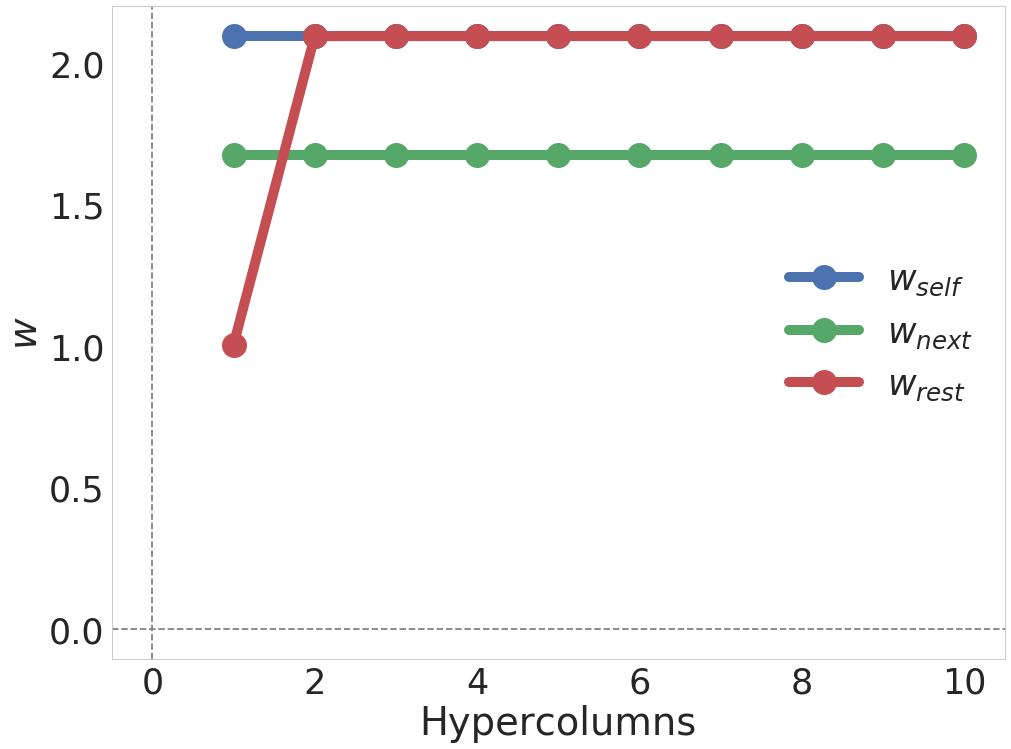

In [107]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(hypercolumns_vector, w_self_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{self}$')
ax.plot(hypercolumns_vector, w_next_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{next}$')
ax.plot(hypercolumns_vector, w_rest_vector, 'o-', markersize=markersize, linewidth=linewidth, label=r'$w_{rest}$')

ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$w$')
ax.set_xlabel(r'Hypercolumns')
ax.legend();

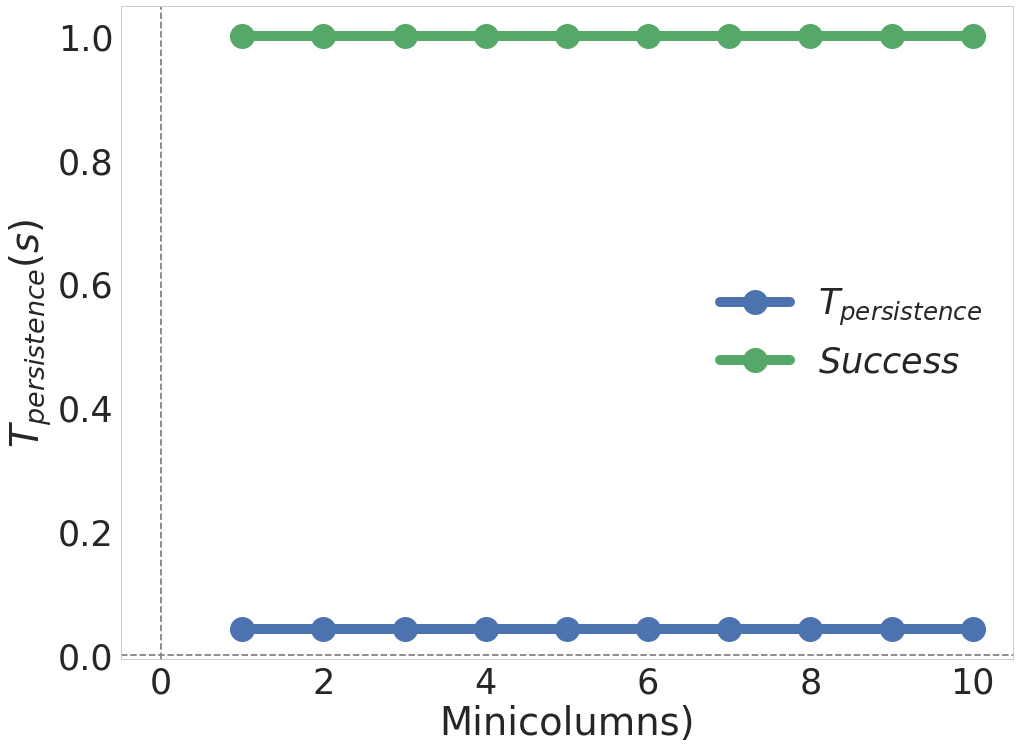

In [108]:
figsize = (16, 12)
markersize = 25
linewidth = 10
normal_palette = sns.color_palette()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.plot(hypercolumns_vector, persistence_time_vector, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$T_{persistence}$')
ax.plot(hypercolumns_vector, success_vector / 100, 'o-', markersize=markersize, 
        linewidth=linewidth, label=r'$Success$')


ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

ax.set_ylabel(r'$T_{persistence} (s)$')
ax.set_xlabel(r'Minicolumns)')
ax.legend();